# Hierarchical model
Hello, today we will try to recreate the hierarchical model as described in *Bishop & Tipping (1998)* in PyStan! In the original model, an *interactive* workflow is presented in which the user determines the number of clusters of latent data and locates their locations for the algorithm. To mimic this approach, we execute the steps of the algorithm individually, while passing the number of clusters and their approximate locations (through a $k$-means clustering algorithm) to the next step.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from sklearn import datasets
import os
import pickle
from utils import loadStan, GAP, hierarchical_model, est_k
sns.set()
from sklearn.metrics import adjusted_rand_score
import csv

In [2]:
ppca_model = loadStan('ppca')
ppca_ard = loadStan('ppca_ard')
gmm_model = loadStan('gmm')
moppcas_model = loadStan('moppcas')
moppcas_weighted = loadStan('moppcas_weighted')
ppca_weighted = loadStan('ppca_weighted')
gmm_weighted = loadStan('gmm_weighted')

Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.


## Loading data
Data used from Nestorowa *et al.* (2016), containing 1656 samples including 4774 genes from, 3 different celltypes.

In [3]:
i=0
with open('coordinates_gene_counts_flow_cytometry.txt', newline = '') as data:                                                                                          
    data_reader = csv.reader(data, delimiter='\t')
    d=list(data_reader)

In [24]:
rawlabels = []
for i in np.array(d)[1:,0]:
    rawlabels.append(i.split('_')[0])

In [27]:
rawdata = np.array(d)[1:,14:]

In [28]:
N, D = np.shape(rawdata)
M = 2

In [29]:
data = []
labels = []
for i in range(N):
    if 'NA' not in rawdata[i]:
        data.append(rawdata[i].astype(np.float))
        labels.append(rawlabels[i])
data = np.array(data)
labels = np.array(labels)

In [30]:
print(data[:5,:5])
print(labels[:5])

[[ 0.          0.         10.05743731  0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 1.27559607  0.          1.94184868  0.          0.        ]]
['HSPC' 'HSPC' 'HSPC' 'HSPC' 'HSPC']


In [31]:
labels = np.unique(labels, return_inverse=True)[1]

In [32]:
N, D = np.shape(data)

In [33]:
print(np.shape(data))
print(np.shape(labels))

(1654, 4290)
(1654,)


In [44]:
# with open('nestorowa.pkl', 'wb') as f:
#     pickle.dump([data, labels], f)

In [47]:
data, labels = pickle.load(open('nestorowa.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(1654, 4290)


## pre-analysis

### Some examples of distributions of genes

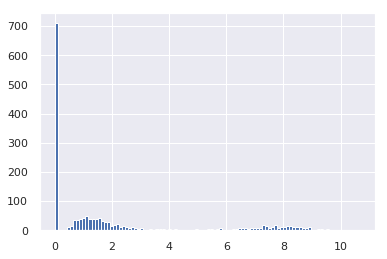

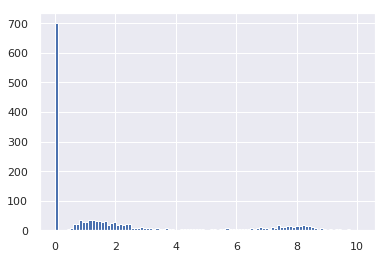

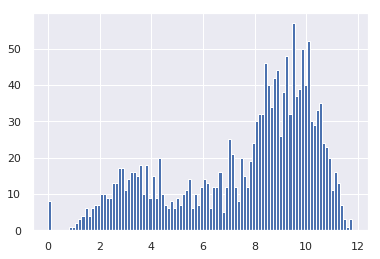

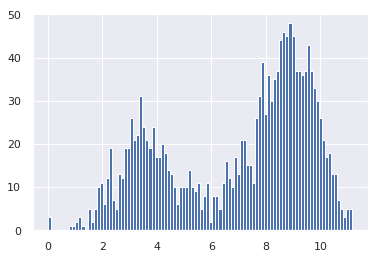

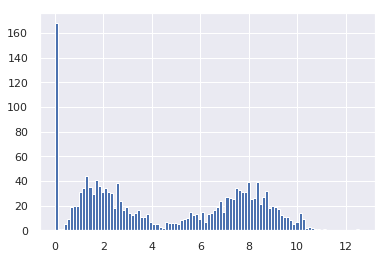

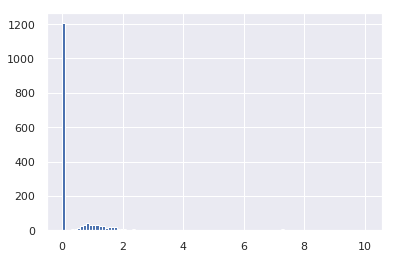

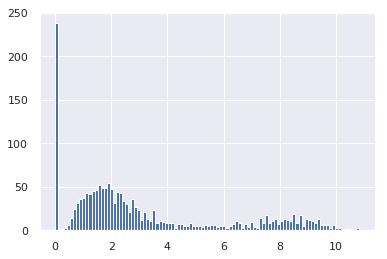

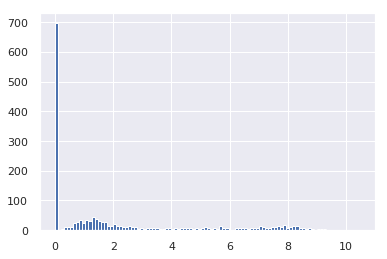

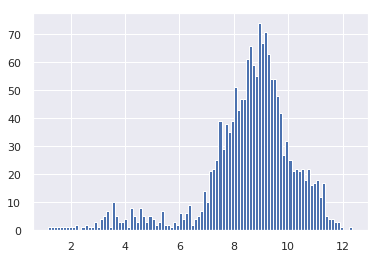

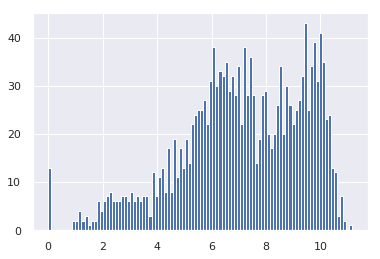

In [48]:
sns.set()
genes = np.random.choice(list(range(D)), p= np.std(data,axis=0)/sum(np.std(data,axis=0)), size=10, replace=False)
for i in range(10):
    plt.hist(data[:,genes[i]], bins=100)
    plt.show()

### Number of clusters is estimated very high, found clusters are not representative of genetype

In [38]:
est_k(data, k_max = 10, verbose=True, method='bic', refs=1)

n_clusters:  1 , AIC:  34083457.4982029 , BIC:  34106670.481749155
n_clusters:  2 , AIC:  33097243.737079263 , BIC:  33143669.70417177
n_clusters:  3 , AIC:  32765941.471452035 , BIC:  32835580.422090795
n_clusters:  4 , AIC:  32569844.29213714 , BIC:  32662696.226322155
n_clusters:  5 , AIC:  32459816.541652814 , BIC:  32575881.459384084
n_clusters:  6 , AIC:  32381279.60728831 , BIC:  32520557.508565832
n_clusters:  7 , AIC:  32335340.88174159 , BIC:  32497831.766565368
n_clusters:  8 , AIC:  32303439.781126723 , BIC:  32489143.649496753
n_clusters:  9 , AIC:  32295710.885811415 , BIC:  32504627.737727698
n_clusters:  10 , AIC:  32302104.009613328 , BIC:  32534233.845075864
9  clusters according to AIC,  8  clusters according to BIC.


(8, KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0))

In [60]:
n_test = 3
labels_test = KMeans(n_test).fit(data).labels_

In [61]:
res = np.zeros((3,n_test))
for r in range(3):
    for t in range(n_test):
        res[r,t] = sum(labels[labels_test==t]==r)
    res[r,:] = res[r,:]/sum(res[r,:])
res

array([[0.7232525 , 0.01141227, 0.26533524],
       [0.85806452, 0.07096774, 0.07096774],
       [0.1641604 , 0.32080201, 0.51503759]])

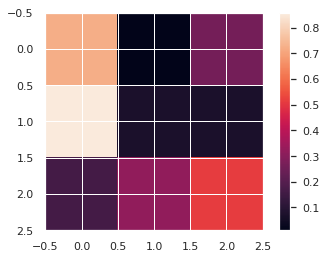

In [62]:
plt.imshow(res)
plt.colorbar()
plt.show()

In [63]:
adjusted_rand_score(labels, labels_test)

0.18670023249756346

### Preprocessing

In [64]:
scores = np.std(data,axis=0)

In [65]:
scores = np.array(scores)
stdscores = []
for j in np.linspace(0,5,100):
    stdscores.append(sum(scores>j))

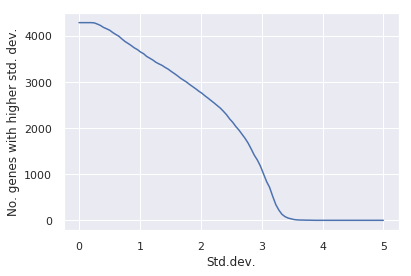

In [66]:
sns.set()
plt.plot(np.linspace(0,5,100), stdscores)
plt.ylabel('No. genes with higher std. dev.')
plt.xlabel('Std.dev.')
plt.show()

In [67]:
genemask = []
for i in range(D):
    if np.std(data[:,i])>np.linspace(0,5,100)[65]:
        genemask.append(True)
    else:
        genemask.append(False)
genemask = np.array(genemask)
print('Using genes with std.dev. of higher than %s'%str(np.linspace(0,5,100)[65]))

Using genes with std.dev. of higher than 3.282828282828283


In [68]:
cropped_data = data[:,genemask]

In [69]:
np.shape(cropped_data)

(1654, 222)

## Analysis

In [ ]:
model = hierarchical_model()
latent, cats_per_lvl, probs = model.fit(cropped_data, max_depth=3)

In [ ]:
plt.scatter(latent[0][0],latent[0][1], c =labels, alpha=0.4)
plt.show()